In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
!cp /content/drive/MyDrive/blur_task/patches.zip .
!unzip /content/patches.zip

In [ ]:
!pip install cpbd
!pip install -U scipy
!pip install -U catboost

In [ ]:
!python -m pip install git+https://github.com/carnotresearch/cr-sparse.git

In [ ]:
!pip install pywavelets

In [ ]:
%%writefile /usr/local/lib/python3.8/dist-packages/cpbd/compute.py
# coding: utf-8

from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)

from math import atan2, pi
from sys import argv

import numpy as np
# from scipy.ndimage import imread
from skimage.feature import canny

from cpbd.octave import sobel


# threshold to characterize blocks as edge/non-edge blocks
THRESHOLD = 0.002

# fitting parameter
BETA = 3.6

# block size
BLOCK_HEIGHT, BLOCK_WIDTH = (64, 64)

# just noticeable widths based on the perceptual experiments
WIDTH_JNB = np.concatenate([5*np.ones(51), 3*np.ones(205)])


def compute(image):
    # type: (numpy.ndarray) -> float
    """Compute the sharpness metric for the given data."""

    # convert the image to double for further processing
    image = image.astype(np.float64)

    # edge detection using canny and sobel canny edge detection is done to
    # classify the blocks as edge or non-edge blocks and sobel edge
    # detection is done for the purpose of edge width measurement.
    canny_edges = canny(image)
    sobel_edges = sobel(image)

    # edge width calculation
    marziliano_widths = marziliano_method(sobel_edges, image)

    # sharpness metric calculation
    return _calculate_sharpness_metric(image, canny_edges, marziliano_widths)


def marziliano_method(edges, image):
    # type: (numpy.ndarray, numpy.ndarray) -> numpy.ndarray
    """
    Calculate the widths of the given edges.

    :return: A matrix with the same dimensions as the given image with 0's at
        non-edge locations and edge-widths at the edge locations.
    """

    # `edge_widths` consists of zero and non-zero values. A zero value
    # indicates that there is no edge at that position and a non-zero value
    # indicates that there is an edge at that position and the value itself
    # gives the edge width.
    edge_widths = np.zeros(image.shape)

    # find the gradient for the image
    gradient_y, gradient_x = np.gradient(image)

    # dimensions of the image
    img_height, img_width = image.shape

    # holds the angle information of the edges
    edge_angles = np.zeros(image.shape)

    # calculate the angle of the edges
    for row in range(img_height):
        for col in range(img_width):
            if gradient_x[row, col] != 0:
                edge_angles[row, col] = atan2(gradient_y[row, col], gradient_x[row, col]) * (180 / pi)
            elif gradient_x[row, col] == 0 and gradient_y[row, col] == 0:
                edge_angles[row,col] = 0
            elif gradient_x[row, col] == 0 and gradient_y[row, col] == pi/2:
                edge_angles[row, col] = 90


    if np.any(edge_angles):

        # quantize the angle
        quantized_angles = 45 * np.round(edge_angles / 45)

        for row in range(1, img_height - 1):
            for col in range(1, img_width - 1):
                if edges[row, col] == 1:

                    # gradient angle = 180 or -180
                    if quantized_angles[row, col] == 180 or quantized_angles[row, col] == -180:
                        for margin in range(100 + 1):
                            inner_border = (col - 1) - margin
                            outer_border = (col - 2) - margin

                            # outside image or intensity increasing from left to right
                            if outer_border < 0 or (image[row, outer_border] - image[row, inner_border]) <= 0:
                                break

                        width_left = margin + 1

                        for margin in range(100 + 1):
                            inner_border = (col + 1) + margin
                            outer_border = (col + 2) + margin

                            # outside image or intensity increasing from left to right
                            if outer_border >= img_width or (image[row, outer_border] - image[row, inner_border]) >= 0:
                                break

                        width_right = margin + 1

                        edge_widths[row, col] = width_left + width_right


                    # gradient angle = 0
                    if quantized_angles[row, col] == 0:
                        for margin in range(100 + 1):
                            inner_border = (col - 1) - margin
                            outer_border = (col - 2) - margin

                            # outside image or intensity decreasing from left to right
                            if outer_border < 0 or (image[row, outer_border] - image[row, inner_border]) >= 0:
                                break

                        width_left = margin + 1

                        for margin in range(100 + 1):
                            inner_border = (col + 1) + margin
                            outer_border = (col + 2) + margin

                            # outside image or intensity decreasing from left to right
                            if outer_border >= img_width or (image[row, outer_border] - image[row, inner_border]) <= 0:
                                break

                        width_right = margin + 1

                        edge_widths[row, col] = width_right + width_left

    return edge_widths


def _calculate_sharpness_metric(image, edges, edge_widths):
    # type: (numpy.array, numpy.array, numpy.array) -> numpy.float64

    # get the size of image
    img_height, img_width = image.shape

    total_num_edges = 0
    hist_pblur = np.zeros(101)

    # maximum block indices
    num_blocks_vertically = int(img_height / BLOCK_HEIGHT)
    num_blocks_horizontally = int(img_width / BLOCK_WIDTH)

    #  loop over the blocks
    for i in range(num_blocks_vertically):
        for j in range(num_blocks_horizontally):

            # get the row and col indices for the block pixel positions
            rows = slice(BLOCK_HEIGHT * i, BLOCK_HEIGHT * (i + 1))
            cols = slice(BLOCK_WIDTH * j, BLOCK_WIDTH * (j + 1))

            if is_edge_block(edges[rows, cols], THRESHOLD):
                block_widths = edge_widths[rows, cols]
                # rotate block to simulate column-major boolean indexing
                block_widths = np.rot90(np.flipud(block_widths), 3)
                block_widths = block_widths[block_widths != 0]

                block_contrast = get_block_contrast(image[rows, cols])
                block_jnb = WIDTH_JNB[block_contrast]

                # calculate the probability of blur detection at the edges
                # detected in the block
                prob_blur_detection = 1 - np.exp(-abs(block_widths/block_jnb) ** BETA)

                # update the statistics using the block information
                for probability in prob_blur_detection:
                    bucket = int(round(probability * 100))
                    hist_pblur[bucket] += 1
                    total_num_edges += 1

    # normalize the pdf
    if total_num_edges > 0:
        hist_pblur = hist_pblur / total_num_edges

    # calculate the sharpness metric
    return np.sum(hist_pblur[:64])


def is_edge_block(block, threshold):
    # type: (numpy.ndarray, float) -> bool
    """Decide whether the given block is an edge block."""
    return np.count_nonzero(block) > (block.size * threshold)


def get_block_contrast(block):
    # type: (numpy.ndarray) -> int
    return int(np.max(block) - np.min(block))


# if __name__ == '__main__':
#     input_image = imread(argv[1], mode='L')
#     sharpness = compute(input_image)
#     print('CPBD sharpness for %s: %f' % (argv[1], sharpness))


Overwriting /usr/local/lib/python3.8/dist-packages/cpbd/compute.py


In [ ]:
import skimage
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import cpbd
from catboost import CatBoostClassifier
import os
import numpy as np
from tqdm import tqdm
import catboost
import scipy
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_auc_score
print(scipy.__version__)
from scipy import fftpack
from scipy.stats import kurtosis 
import pywt

1.9.3


In [ ]:

def wavelet_metric(img, threshold=0.05):
    
    # Convert image to grayscale
    # Y = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    Y=img.copy()
    M, N = Y.shape
    
    # Crop input image to be 3 divisible by 2
    Y = Y[0:int(M/16)*16, 0:int(N/16)*16]
    
    # Step 1, compute Haar wavelet of input image
    LL1,(LH1,HL1,HH1)= pywt.dwt2(Y, 'haar')
    # Another application of 2D haar to LL1
    LL2,(LH2,HL2,HH2)= pywt.dwt2(LL1, 'haar') 
    # Another application of 2D haar to LL2
    LL3,(LH3,HL3,HH3)= pywt.dwt2(LL2, 'haar')
    
    # Construct the edge map in each scale Step 2
    E1 = np.sqrt(np.power(LH1, 2)+np.power(HL1, 2)+np.power(HH1, 2))
    E2 = np.sqrt(np.power(LH2, 2)+np.power(HL2, 2)+np.power(HH2, 2))
    E3 = np.sqrt(np.power(LH3, 2)+np.power(HL3, 2)+np.power(HH3, 2))
    
    M1, N1 = E1.shape

    # Sliding window size level 1
    sizeM1 = 8
    sizeN1 = 8
    
    # Sliding windows size level 2
    sizeM2 = int(sizeM1/2)
    sizeN2 = int(sizeN1/2)
    
    # Sliding windows size level 3
    sizeM3 = int(sizeM2/2)
    sizeN3 = int(sizeN2/2)
    
    # Number of edge maps, related to sliding windows size
    N_iter = int((M1/sizeM1)*(N1/sizeN1))
    
    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))
    
    
    count = 0
    
    # Sliding windows index of level 1
    x1 = 0
    y1 = 0
    # Sliding windows index of level 2
    x2 = 0
    y2 = 0
    # Sliding windows index of level 3
    x3 = 0
    y3 = 0
    
    # Sliding windows limit on horizontal dimension
    Y_limit = N1-sizeN1
    
    while count < N_iter:
        # Get the maximum value of slicing windows over edge maps 
        # in each level
        Emax1[count] = np.max(E1[x1:x1+sizeM1,y1:y1+sizeN1])
        Emax2[count] = np.max(E2[x2:x2+sizeM2,y2:y2+sizeN2])
        Emax3[count] = np.max(E3[x3:x3+sizeM3,y3:y3+sizeN3])
        
        # if sliding windows ends horizontal direction
        # move along vertical direction and resets horizontal
        # direction
        if y1 == Y_limit:
            x1 = x1 + sizeM1
            y1 = 0
            
            x2 = x2 + sizeM2
            y2 = 0
            
            x3 = x3 + sizeM3
            y3 = 0
            
            count += 1
        
        # windows moves along horizontal dimension
        else:
                
            y1 = y1 + sizeN1
            y2 = y2 + sizeN2
            y3 = y3 + sizeN3
            count += 1
    
    # Step 3
    EdgePoint1 = Emax1 > threshold;
    EdgePoint2 = Emax2 > threshold;
    EdgePoint3 = Emax3 > threshold;
    
    # Rule 1 Edge Pojnts
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3
    
    n_edges = EdgePoint.shape[0]
    
    # Rule 2 Dirak-Structure or Astep-Structure
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint]);
    
    # Rule 3 Roof-Structure or Gstep-Structure
    
    RGstructure = np.zeros((n_edges))

    for i in range(n_edges):
    
        if EdgePoint[i] == 1:
        
            if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
            
                RGstructure[i] = 1
                
    # Rule 4 Roof-Structure
    
    RSstructure = np.zeros((n_edges))

    for i in range(n_edges):
    
        if EdgePoint[i] == 1:
        
            if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:
            
                RSstructure[i] = 1

    # Rule 5 Edge more likely to be in a blurred image 

    BlurC = np.zeros((n_edges));

    for i in range(n_edges):
    
        if RGstructure[i] == 1 or RSstructure[i] == 1:
        
            if Emax1[i] < threshold:
            
                BlurC[i] = 1                        
        
    # Step 6
    Per = np.sum(DAstructure)/np.sum(EdgePoint)
    
    # Step 7
    if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
        
        BlurExtent = 100
    else:
        BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))
    
    return Per, BlurExtent

In [ ]:
def generate_points(n, ax, ay):
  y  = [i+ay for i in range(-n, n+1)]
  x  = [i+ax for i in range(-n, n+1)]
  points = []
  for i in range(len(y)):
    for j in range(len(x)):
      points.append([x[i], y[j]])
  return points

def get_local_features(x, metric, **kwagrs):
  metric_features=[]  
  for i in range(2, x.shape[0]):


    local_features = metric(x[0:i, 0:i])
    if np.isnan(local_features).any():
      pass
    else:
      metric_features.append(local_features)
      # try:
        
      # except TypeError:
      #   metric_features.append(local_features)


    local_features = metric(x[0:x.shape[0]-i, 0:i])
    if np.isnan(local_features).any():
      pass
    else:
     metric_features.append(local_features)


    local_features = metric(x[0:i, 0:x.shape[0]-i])
    if np.isnan(local_features).any():
      pass
    else:
      metric_features.append(local_features)

    local_features = metric(x[x.shape[0]-i-1, i])
    if np.isnan(local_features).any():
      pass
    else:
      metric_features.append(local_features)
 
  return np.asarray(metric_features)

def fourier(image):
  try:
    F1 = np.fft.fft2(image)
  except:
    return np.nan
  

  # Now shift the quadrants around so that low spatial frequencies are in
  # the center of the 2D fourier transformed image.
  # F2 = np.fft.fftshift( F1 )
  # print(kvals, Abins)
  # assert 1 ==0 
  # Calculate a 2D power spectrum
  psd2D = np.abs( F1)**2
  psd2D.flatten()
  
  return psd2D

def get_median_features(x, metric=kurtosis, num_bins=10):
  
  features = get_local_features(x, metric)
  
  features_binned = []

  for i in range(len(features)):
    data = features[i].flatten()

    mn = min(data)
    mx = max(data)

    bin_means = binned_statistic(data, data, bins=num_bins, range=(mn, mx))[0]
    
    # print(bin_means)
    features_binned.append(np.mean(bin_means[~np.isnan(bin_means)]))
  return features_binned

In [ ]:
def get_features(labels=None, path="patches/patches_128/", metric=kurtosis, size=128, class_weights='Default'):
  cbpd_features = []
  wavelet_features = []

  labels = pd.read_csv(os.path.join(path, 'labels.csv')) if labels is None else labels
  indexes = []
  print()
  if class_weights == 'equal':
    for row in range(len(labels)):
      if labels.iloc[row]['0'] == 0:
        if labels['0'].value_counts()[0] - len(indexes) != labels['0'].value_counts()[1]:
          indexes.append(row)
        else:
          break
  labels.drop(index=indexes, inplace=True)
  print(labels['0'].value_counts())

  # assert 1 == 0
  metric_features = []
  y = []
  for i in tqdm(labels.iloc):
    im = cv2.imread(os.path.join(path,f"patch_{i['Unnamed: 0']}.png"))  
    # print(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (size, size))
    # print(wavelet(im).shape)
  

    im_features = get_median_features(im, metric)
    # print(im_features)
    # if np.isnan(np.asarray(im_features)).any():
    #   continue
    c1, c2 = wavelet_metric(im)
    wavelet_features.append(c1)
    cbpd_features.append(cpbd.compute(im))
    metric_features.append(im_features)

    y.append(i['0'])
  max_len = max([len(x) for x in metric_features])
  output = [np.pad(x, (0, max_len - len(x)), 'constant')  for x in metric_features]
  return output, y, cbpd_features, wavelet_features

In [ ]:
X, y, global_features, wavelet_features = get_features(path="patches/patches_64/", metric=fourier, size = 224)



0    9534

1     798

Name: 0, dtype: int64


0it [00:00, ?it/s]<ipython-input-9-220b439f60f6>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  return np.asarray(metric_features)

0it [00:01, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(X, columns = [f"dim_{i}" for i in range(len(X[0]))])
df['metric'] = y
# df['cpbd'] = global_features
# df['wavelet'] = wavelet_features

In [ ]:
model = CatBoostClassifier(loss_function='Logloss',  eval_metric='F1' ,grow_policy ='Lossguide',random_seed=2809384,auto_class_weights='Balanced', simple_ctr='Buckets', boosting_type='Plain')

grid = {
        'learning_rate': [ 0.005,  0.00005, 0.05],
        'depth': [9,  5, 15],
        # 'iterations':[75],
        'l2_leaf_reg': [1, 0.4],
        'rsm': [0.3, 0.7],
        'subsample':[1.0],
        'bootstrap_type':['MVS'],
        'max_leaves':[15, 25],
        'n_estimators':[75]
        }

grid_search_result = model.grid_search(grid,
                                       X=df.drop(columns=['metric']),
                                       y=df.metric,
                                      verbose=True)
grid_search_result

In [ ]:
grid_search_result['params']

{'max_leaves': 25,
 'depth': 15,
 'l2_leaf_reg': 1,
 'iterations': 75,
 'subsample': 1.0,
 'rsm': 0.3,
 'learning_rate': 5e-05,
 'bootstrap_type': 'MVS'}

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2)
y_train = X_train.metric
X_train = X_train.drop(columns=['metric'])

y_test = X_test.metric
X_test = X_test.drop(columns=['metric'])


In [ ]:
params = {'max_leaves': 15,
 'depth': 100,
 'l2_leaf_reg': 1,
 'iterations': 300,
 'subsample': 1.0,
 'rsm': 0.3,
 'learning_rate': 0.0001,
 'bootstrap_type': 'MVS'}
#  grid_search_result['params']
# params['learning_rate'] = 0.004
model = CatBoostClassifier(loss_function='Logloss',  eval_metric='AUC' ,grow_policy ='Lossguide',random_seed=2809384,auto_class_weights='Balanced', **grid_search_result['params'])


In [ ]:
from catboost import Pool
train_dataset = Pool(X_train, y_train)
eval_set = Pool(X_test, y_test)

model.fit(train_dataset, verbose=True,use_best_model=True, eval_set=eval_set)

In [ ]:
!mkdir inference
%cd inference
!cp /content/drive/MyDrive/blur_task/inference_224.zip .
!unzip inference_224.zip

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-21-2d532e1c97bb>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

  return np.asarray(metric_features)

100%|██████████| 7/7 [00:06<00:00,  1.00it/s]

cp: cannot stat '/content/infere_64.png': No such file or directory


[]

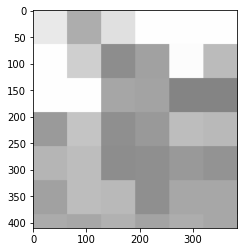

In [ ]:
from tqdm import trange
def sliding_window(im_path, stepSize, windowSize, metric, classifier):
  image = cv2.imread(im_path)
  cbpd_features = []
  wavelet_features = []
  names = []
  metric_features = []
  for y in trange(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      crop = image[y:y + windowSize[1], x:x + windowSize[0]]
      crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
      crop = cv2.resize(crop, windowSize)
      im_features = get_median_features(crop, metric)
      c1, c2 = blur_detect(crop)
      cpbd_global_metric= cpbd.compute(crop)
      wavelet_features.append(c1)
      cbpd_features.append(cpbd_global_metric)
      metric_features.append(im_features)
      names.append(f"patch_{x//stepSize}_{y // stepSize}.png")
  max_len = max([len(x) for x in metric_features])    
  output = [np.pad(x, (0, max_len - len(x)), 'constant')  for x in metric_features]
  df = pd.DataFrame(output, columns = [f"dim_{i}" for i in range(len(output[0]))])

  df['cpbd'] = cbpd_features
  df['wavelet'] = wavelet_features
  preds = np.max(classifier.predict_proba(df), axis=1)
  dd = {names[i]:preds[i] for i in range(len(names))}
  inference_result = image.copy()
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      crop = image[y:y + windowSize[1], x:x + windowSize[0]]
      heat_level = dd[ f"patch_{x//stepSize}_{y // stepSize}.png"]*255
      inference_result[y:y + windowSize[1], x:x + windowSize[0]] = heat_level
  return inference_result
  
window_size = 64
filename= '003.jpg'
img = sliding_window(f'/content/{filename}', window_size, (window_size, window_size), metric = fourier, classifier=model)
cv2.imwrite('003_test_inference_64.jpg', img)
!cp /content/infere_64.png /content/drive/MyDrive/blur_task/
plt.imshow(img)
plt.plot()

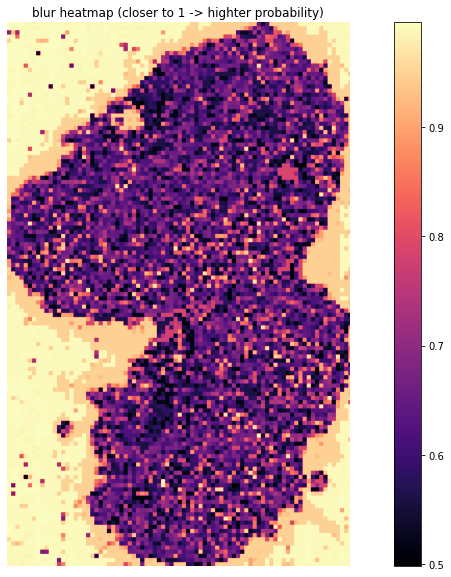

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("blur heatmap (closer to 1 -> highter probability)")
plt.axis('off')
plt.imshow(img[:, :, 0]/255, cmap='magma')
plt.colorbar()
# plt.savefig('01_heatmap.png')
plt.show()


get_median_features